In [1]:
import sys, os, glob
sys.path.append('/home/gddaslab/mxp140/tcr_project_ultimate')
from pdf import pdf, ci_pdf
from constants import patient_names, max_kr_panpep, max_kr_vdjdb, max_kr_mcpas

In [2]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import ttest_ind, linregress

In [5]:
pooled_data_filename_for_panpep = "/home/gddaslab/mxp140/tcr_project_ultimate/data/BrMET_and_GBM_data-PANPEP.csv"
pooled_data_filename_for_ergo2 = "/home/gddaslab/mxp140/tcr_project_ultimate/data/BrMET_and_GBM_data-ERGOII.csv"
find_regionwise_data_filename_for_panpep_in = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP"
find_regionwise_data_filename_for_ergo2_in = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII"

asterisk = '\u2217'
p_value_stars = {0.001: f'{asterisk}{asterisk}{asterisk}', 0.01: f'{asterisk}{asterisk}', 0.05: f'{asterisk}'}
def get_asterisks(p_value):
    for threshold in sorted(p_value_stars.keys()):
        if p_value < threshold:
            return p_value_stars[threshold]
    return 'ns'

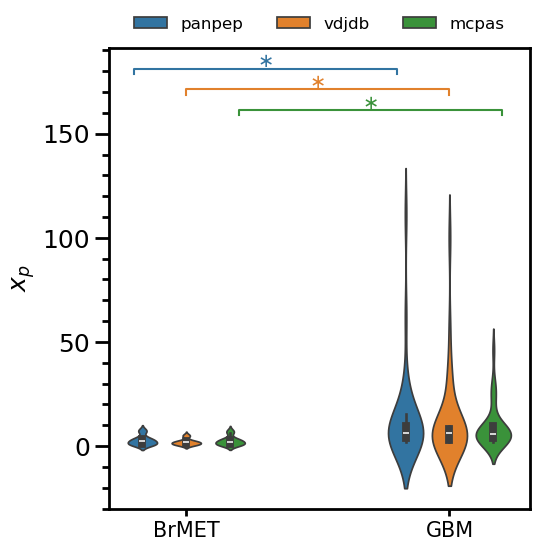

In [6]:
def fig3a_left():
    params_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters', )
    params_df = params_df[~params_df['Region'].str.contains('combined')]
    params_df = params_df.dropna(axis=0)
    
    resulting_df = pd.DataFrame(columns=['patient', 'panpep', 'vdjdb', 'mcpas'])
    resulting_df['patient'] = ['BrMET' if 'BrMET' in patient_id else 'GBM' for patient_id in params_df['Patient']]
    resulting_df['panpep'] = params_df['x2_panpep'].values
    resulting_df['vdjdb'] = params_df['x2_vdjdb'].values
    resulting_df['mcpas'] = params_df['x2_mcpas'].values
    
    # # Melt the DataFrame to long format
    df_melted = resulting_df.melt(id_vars='patient', value_vars=['panpep', 'vdjdb', 'mcpas'], var_name='type', value_name='value')
    df_melted = df_melted.dropna(axis=0)
    
    p_value_panpep = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='panpep')]['value'].values, 
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='panpep')]['value'].values, equal_var=False).pvalue
    p_value_vdjdb = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='vdjdb')]['value'].values, 
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='vdjdb')]['value'].values, equal_var=False).pvalue
    p_value_mcpas = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='mcpas')]['value'].values,
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='mcpas')]['value'].values, equal_var=False).pvalue
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.75*2, 2.79*2))
    violinplot = sns.violinplot(x='patient', y='value', hue='type', data=df_melted, ax=ax, inner='box', width=0.5, density_norm='count', gap=0.2)
    ax.grid(False)
    
    x1s = [-0.2, 0, 0.2]
    x2s = [0.8, 1.0, 1.2]
    ys= [180, 170, 160]
    hs = [2.5, 2.5, 2.5]
    colors = [patch.get_facecolor() for patch in violinplot.patches]
    for x1, x2, y, h, color in zip(x1s, x2s, ys, hs, colors):
        ax.plot([x1, x1, x2, x2], [y - h / 2, y + h / 2, y + h / 2, y - h / 2], lw=1.5, c=color)
        ax.text((x1 + x2) * .5, y + h * 0.1, f'{get_asterisks(p_value_panpep)}', ha='center', va='bottom', color=color, fontsize=14)
    
    ax.set_ylabel(r'$x_p$', fontsize=18)
    ax.set_xlabel('')
    
    for label in ax.get_xticklabels():
        label.set_fontsize(14)
    for label in ax.get_yticklabels():
        label.set_fontsize(18)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.tick_params(
        axis="x", which="major", direction="out", length=5, width=2, labelsize=15
    )
    ax.tick_params(
        axis="y", which="major", direction="out", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="out", length=5, width=2, labelsize=18
    )
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.10),
        ncol=3,
        fontsize=12,
        frameon=False
    )
    plt.tight_layout()
    plt.savefig('fig3a_left.png', format='png', bbox_inches='tight', dpi=320)
    plt.show()
    # print(resulting_df)
fig3a_left()

/tmp/ipykernel_2534066/652299474.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resulting_df = pd.concat([resulting_df, region_df], ignore_index=True)


Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.
So, `None` values are added for ERGOII to match the shape of the resulting_df. Ignore NaNs when plotting for ERGOII.


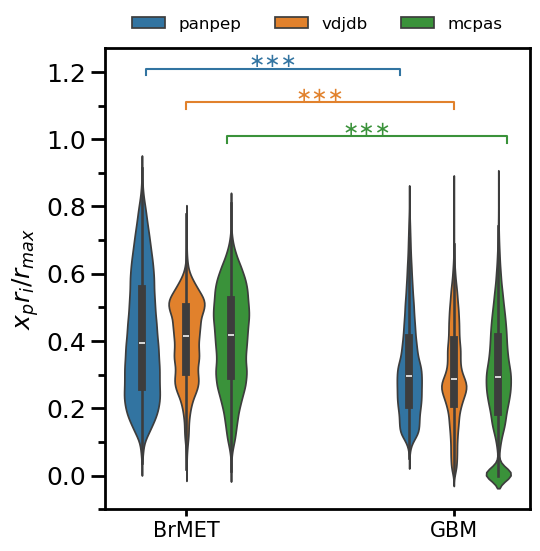

In [17]:
def fig3a_right():
    params_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters', )
    params_df = params_df[~params_df['Region'].str.contains('combined')]
    params_df = params_df.dropna(axis=0)
    
    resulting_df = pd.DataFrame(columns=['patient', 'panpep', 'vdjdb', 'mcpas'])
    for patient_id in patient_names:
        filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
        filepath_format_for_ergo2 = os.path.join(find_regionwise_data_filename_for_ergo2_in, patient_id, f"{patient_id}_region*.csv")
        
        full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
        full_filepath_for_ergo2 = glob.glob(filepath_format_for_ergo2)
        
        sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
        sorted_by_region_full_filepath_for_ergo2 = sorted(full_filepath_for_ergo2, key=lambda x: int(x.split("region")[1].split(".")[0]))
        
        for file_panpep, file_ergo2 in zip(sorted_by_region_full_filepath_for_panpep, sorted_by_region_full_filepath_for_ergo2):
            region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
            region_number_ergo2 = int(file_ergo2.split("region")[1].split(".")[0])
            
            if region_number_panpep == region_number_ergo2:
                kr_values_panpep = pd.read_csv(file_panpep, sep=',')['kr'].values
                kr_values_vdjdb = pd.read_csv(file_ergo2, sep=',')['kr_vdjdb'].values
                kr_values_mcpas = pd.read_csv(file_ergo2, sep=',')['kr_mcpas'].values
                
                len_kr_panpep = kr_values_panpep.shape[0]
                len_kr_vdjdb = kr_values_vdjdb.shape[0]
                len_kr_mcpas = kr_values_mcpas.shape[0]
                max_len = max(len_kr_panpep, len_kr_vdjdb, len_kr_mcpas)
                # print(len_kr_panpep, len_kr_vdjdb, max_len)
                
                x2_panpep = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_panpep}')])['x2_panpep'].values[0]
                x2_vdjdb = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_ergo2}')])['x2_vdjdb'].values[0]
                x2_mcpas = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_ergo2}')])['x2_mcpas'].values[0]
                
                region_df = pd.DataFrame({'patient':'BrMET' if 'BrMET' in patient_id else 'GBM',
                                          'panpep':x2_panpep * kr_values_panpep/max_kr_panpep,
                                          'vdjdb':list(x2_vdjdb * kr_values_vdjdb/max_kr_vdjdb) + [None]*(max_len - len_kr_vdjdb),
                                          'mcpas':list(x2_mcpas * kr_values_mcpas/max_kr_mcpas) + [None]*(max_len - len_kr_mcpas)})
                resulting_df = pd.concat([resulting_df, region_df], ignore_index=True)
            else:
                raise ValueError('The region numbers do not match.')
    print('Note: The kr values array from PANPEP are longer than that from  VDJDB and MCPAS because PANPEP have more TCRs than ERGOII.\nSo, `None` values are added for ERGOII to match the shape of the resulting_df. Ignore NaNs when plotting for ERGOII.')

    # Melt the DataFrame to long format
    df_melted = resulting_df.melt(id_vars='patient', value_vars=['panpep', 'vdjdb', 'mcpas'], var_name='type', value_name='value')
    df_melted = df_melted.dropna(axis=0)
    
    p_value_panpep = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='panpep')]['value'].values, 
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='panpep')]['value'].values, equal_var=False).pvalue
    p_value_vdjdb = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='vdjdb')]['value'].values, 
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='vdjdb')]['value'].values, equal_var=False).pvalue
    p_value_mcpas = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='mcpas')]['value'].values,
                                df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='mcpas')]['value'].values, equal_var=False).pvalue
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.75*2, 2.79*2))
    violinplot = sns.violinplot(x='patient', y='value', hue='type', data=df_melted, ax=ax, inner='box', width=0.5, density_norm='count', gap=0.2)
    
    x1s = [-0.15, 0, 0.15]
    x2s = [0.8, 1.0, 1.2]
    ys= [1.2, 1.1, 1.0]
    hs = [0.02, 0.02, 0.02]
    colors = [patch.get_facecolor() for patch in violinplot.patches]
    for x1, x2, y, h, color in zip(x1s, x2s, ys, hs, colors):
        ax.plot([x1, x1, x2, x2], [y - h / 2, y + h / 2, y + h / 2, y - h / 2], lw=1.5, c=color)
        ax.text((x1 + x2) * .5, y + h * 0.1, f'{get_asterisks(p_value_panpep)}', ha='center', va='bottom', color=color, fontsize=14)
        
    ax.grid(False)
    ax.set_ylabel(r'$x_p r_i$/$r_{max}$', fontsize=18)
    ax.set_xlabel('')
    
    for label in ax.get_xticklabels():
        label.set_fontsize(14)
    for label in ax.get_yticklabels():
        label.set_fontsize(18)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.tick_params(
        axis="x", which="major", direction="out", length=5, width=2, labelsize=15
    )
    ax.tick_params(
        axis="y", which="major", direction="out", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="out", length=5, width=2, labelsize=18
    )
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.10),
        ncol=3,
        fontsize=12,
        frameon=False
    )
    
    p_value_panpep = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='panpep')]['value'], df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='panpep')]['value'], equal_var=False).pvalue
    p_value_vdjdb = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='vdjdb')]['value'], df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='vdjdb')]['value'], equal_var=False).pvalue
    p_value_mcpas = ttest_ind(df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='mcpas')]['value'], df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='mcpas')]['value'], equal_var=False).pvalue
    
    # print(get_asterisks(p_value_panpep))
    # print(get_asterisks(p_value_vdjdb))
    # print(get_asterisks(p_value_mcpas))
    
    # annotations = [(('panpep', 'BrMET'), ('panpep', 'GBM'), p_value_panpep),]
    # starbars.draw_annotation(annotations=annotations)
    
    plt.tight_layout()
    plt.savefig('fig3a_right.png', format='png', bbox_inches='tight', dpi=320)
    plt.show()
    return ax
a = fig3a_right()
    

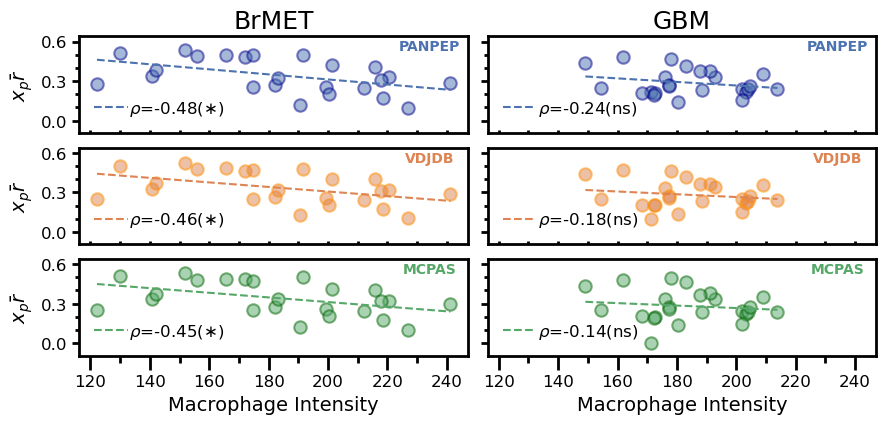

In [20]:
def fig3c_left():
    macrophage = pd.read_csv('/home/gddaslab/mxp140/tcr_project_ultimate/data/cell_popns.csv', usecols=['patient', 'macrophage_R', 'macrophage_G', 'macrophage_B'])
    macrophage['intensity'] = (macrophage['macrophage_R'] * 0.299) + (macrophage['macrophage_G'] * 0.587) + (macrophage['macrophage_B'] * 0.114)
    macrophage = macrophage.drop(columns=['macrophage_R', 'macrophage_G', 'macrophage_B'])
    
    params_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters', )
    params_df = params_df[~params_df['Region'].str.contains('combined')]
    params_df = params_df.dropna(axis=0)
    
    resulting_df = pd.DataFrame(columns=['patient', 'panpep', 'vdjdb', 'mcpas'])
    for patient_id in patient_names:
        filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
        filepath_format_for_ergo2 = os.path.join(find_regionwise_data_filename_for_ergo2_in, patient_id, f"{patient_id}_region*.csv")
        
        full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
        full_filepath_for_ergo2 = glob.glob(filepath_format_for_ergo2)
        
        sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
        sorted_by_region_full_filepath_for_ergo2 = sorted(full_filepath_for_ergo2, key=lambda x: int(x.split("region")[1].split(".")[0]))
        
        for file_panpep, file_ergo2 in zip(sorted_by_region_full_filepath_for_panpep, sorted_by_region_full_filepath_for_ergo2):
            region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
            region_number_ergo2 = int(file_ergo2.split("region")[1].split(".")[0])
            
            if region_number_panpep == region_number_ergo2:
                mean_kr_values_panpep = pd.read_csv(file_panpep, sep=',')['kr'].values.mean()
                mean_kr_values_vdjdb = pd.read_csv(file_ergo2, sep=',')['kr_vdjdb'].values.mean()
                mean_kr_values_mcpas = pd.read_csv(file_ergo2, sep=',')['kr_mcpas'].values.mean()
                
                x2_panpep = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_panpep}')])['x2_panpep'].values[0]
                x2_vdjdb = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_ergo2}')])['x2_vdjdb'].values[0]
                x2_mcpas = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_ergo2}')])['x2_mcpas'].values[0]
                
                new_row = pd.Series({'patient':'BrMET' if 'BrMET' in patient_id else 'GBM',
                                    'panpep':x2_panpep * mean_kr_values_panpep/max_kr_panpep,
                                    'vdjdb':x2_vdjdb * mean_kr_values_vdjdb/max_kr_vdjdb,
                                    'mcpas':x2_mcpas * mean_kr_values_mcpas/max_kr_mcpas,
                                    'intensity':macrophage[macrophage['patient'].eq(f'{patient_id}-region{region_number_panpep}')]['intensity'].values[0] if f'{patient_id}-region{region_number_panpep}' in macrophage['patient'].values else None
                                    })
                resulting_df = pd.concat([resulting_df, new_row.to_frame().T], ignore_index=True)
            else:
                raise ValueError('The region numbers do not match.')
    # Melt the DataFrame to long format
    df_melted = resulting_df.melt(id_vars=['patient', 'intensity'], value_vars=['panpep', 'vdjdb', 'mcpas'], var_name='type', value_name='x2kr')
    df_melted = df_melted.dropna(axis=0)

    nrows, ncols = 3, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9.35*1.1, 3.77*1.1), sharex=True, sharey=True, gridspec_kw={'wspace':0.05, 'hspace':0.15})
    
    data00 = df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='panpep')]
    data01 = df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='panpep')]
    data10 = df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='vdjdb')]
    data11 = df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='vdjdb')]
    data20 = df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='mcpas')]
    data21 = df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='mcpas')]
    
    data = [[data00, data01], [data10, data11], [data20, data21]]
    text = ['PANPEP', 'VDJDB', 'MCPAS']
    colors = sns.color_palette("deep")[:3]
    
    axes[0, 0].set_title('BrMET', fontsize=18)
    axes[0, 1].set_title('GBM', fontsize=18)
    
    miny = min([data[i][j]['x2kr'].min() for i in range(nrows) for j in range(ncols)])
    maxy = max([data[i][j]['x2kr'].max() for i in range(nrows) for j in range(ncols)])
    
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i, j]
            sns.scatterplot(data=data[i][j], x='intensity', y='x2kr', s=80, ax=ax, facecolors=colors[i], alpha=0.5, edgecolors=['darkblue', 'darkorange', 'darkgreen'][i], linewidth=1.5)
            
            ax.set_ylim(bottom=miny-0.1, top=maxy+0.1)
            
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                
            if j == 0:
                ax.set_ylabel(r'$x_p\bar{r}$', fontsize=14)
                ax.yaxis.set_major_locator(ticker.MultipleLocator(0.3))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
            
            if i == 2:
                ax.set_xlabel('Macrophage Intensity', fontsize=14)
                ax.set_xlabel('Macrophage Intensity', fontsize=14)
                ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
                ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
                ax.tick_params(axis="x", which="major", direction="out", length=10, width=2, labelsize=12)
                ax.tick_params(axis="x", which="minor", direction="out", length=5, width=2, labelsize=12) 
            
            ax.tick_params(axis="y", which="major", direction="out", length=5, width=2, labelsize=12)
            ax.tick_params(axis="y", which="minor", direction="out", length=3, width=2, labelsize=12)    
            ax.text(0.9, 0.97, text[i], ha='center', va='top', transform=axes[i, j].transAxes, fontsize=10, fontweight='semibold', color=colors[i])
                
            if i != 2:
                ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
                ax.tick_params(axis="x", which="major", direction="in", length=2, width=2, labelsize=14)
                ax.tick_params(axis="x", which="minor", direction="in", length=2, width=2, labelsize=14) 
            
            x, y = data[i][j]['intensity'].astype(float), data[i][j]['x2kr'].astype(float)
            slope, intercept, r_value, p_value, _ = linregress(x, y)
            # print(i, j, p_value)
            x_vals = np.linspace(x.min(), x.max(), 100)
            y_vals = slope*x_vals + intercept
            ax.plot(x_vals, y_vals, '--', color=colors[i], label=fr'$\rho$={r_value:.2f}({get_asterisks(p_value)})') # (which is a centered asterisk)
            ax.legend(loc='lower left', fontsize=12, frameon=False, handletextpad=0.1)
    
    # plt.tight_layout()
    plt.savefig('fig3c.png', format='png', bbox_inches='tight', dpi=320)
    plt.show()
    
a = fig3c_left()

/tmp/ipykernel_1618221/2044480420.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


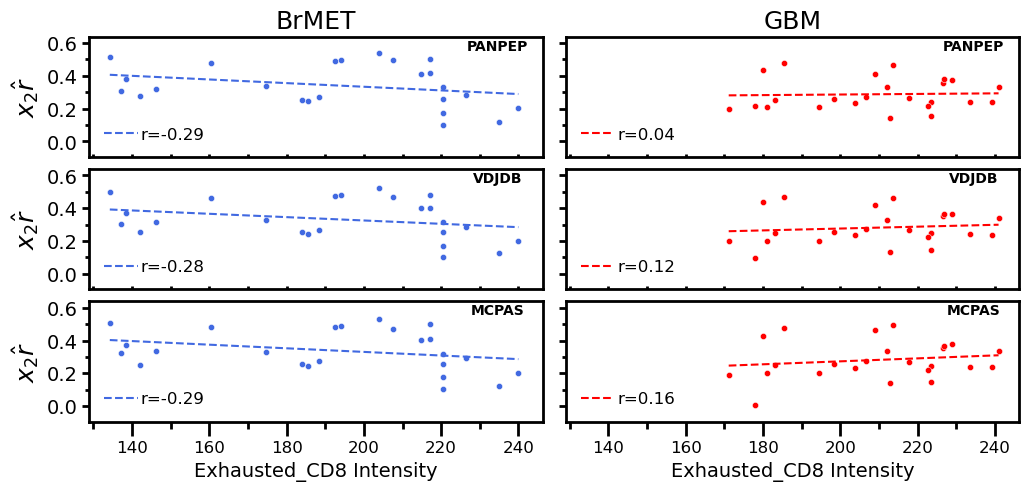

In [53]:
def fig3c_right():
    exhausted_cd8 = pd.read_csv('/home/gddaslab/mxp140/tcr_project_ultimate/data/cell_popns.csv', usecols=['patient', 'exhausted_cd8_R', 'exhausted_cd8_G', 'exhausted_cd8_B'])
    exhausted_cd8['intensity'] = (exhausted_cd8['exhausted_cd8_R'] * 0.299) + (exhausted_cd8['exhausted_cd8_G'] * 0.587) + (exhausted_cd8['exhausted_cd8_B'] * 0.114)
    exhausted_cd8 = exhausted_cd8.drop(columns=['exhausted_cd8_R', 'exhausted_cd8_G', 'exhausted_cd8_B'])
    
    params_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters', )
    params_df = params_df[~params_df['Region'].str.contains('combined')]
    params_df = params_df.dropna(axis=0)
    
    resulting_df = pd.DataFrame(columns=['patient', 'panpep', 'vdjdb', 'mcpas'])
    for patient_id in patient_names:
        filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
        filepath_format_for_ergo2 = os.path.join(find_regionwise_data_filename_for_ergo2_in, patient_id, f"{patient_id}_region*.csv")
        
        full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
        full_filepath_for_ergo2 = glob.glob(filepath_format_for_ergo2)
        
        sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
        sorted_by_region_full_filepath_for_ergo2 = sorted(full_filepath_for_ergo2, key=lambda x: int(x.split("region")[1].split(".")[0]))
        
        for file_panpep, file_ergo2 in zip(sorted_by_region_full_filepath_for_panpep, sorted_by_region_full_filepath_for_ergo2):
            region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
            region_number_ergo2 = int(file_ergo2.split("region")[1].split(".")[0])
            
            if region_number_panpep == region_number_ergo2:
                mean_kr_values_panpep = pd.read_csv(file_panpep, sep=',')['kr'].values.mean()
                mean_kr_values_vdjdb = pd.read_csv(file_ergo2, sep=',')['kr_vdjdb'].values.mean()
                mean_kr_values_mcpas = pd.read_csv(file_ergo2, sep=',')['kr_mcpas'].values.mean()
                
                x2_panpep = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_panpep}')])['x2_panpep'].values[0]
                x2_vdjdb = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_ergo2}')])['x2_vdjdb'].values[0]
                x2_mcpas = (params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number_ergo2}')])['x2_mcpas'].values[0]
                
                new_row = pd.Series({'patient':'BrMET' if 'BrMET' in patient_id else 'GBM',
                                    'panpep':x2_panpep * mean_kr_values_panpep/max_kr_panpep,
                                    'vdjdb':x2_vdjdb * mean_kr_values_vdjdb/max_kr_vdjdb,
                                    'mcpas':x2_mcpas * mean_kr_values_mcpas/max_kr_mcpas,
                                    'intensity':exhausted_cd8[exhausted_cd8['patient'].eq(f'{patient_id}-region{region_number_panpep}')]['intensity'].values[0] if f'{patient_id}-region{region_number_panpep}' in exhausted_cd8['patient'].values else None
                                    })
                resulting_df = pd.concat([resulting_df, new_row.to_frame().T], ignore_index=True)
            else:
                raise ValueError('The region numbers do not match.')
    # Melt the DataFrame to long format
    df_melted = resulting_df.melt(id_vars=['patient', 'intensity'], value_vars=['panpep', 'vdjdb', 'mcpas'], var_name='type', value_name='x2kr')
    df_melted = df_melted.dropna(axis=0)

    nrows, ncols = 3, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5), sharex=True, sharey=True, gridspec_kw={'wspace':0.05, 'hspace':0.1})
    
    data00 = df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='panpep')]
    data01 = df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='panpep')]
    data10 = df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='vdjdb')]
    data11 = df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='vdjdb')]
    data20 = df_melted[(df_melted['patient']=='BrMET') & (df_melted['type']=='mcpas')]
    data21 = df_melted[(df_melted['patient']=='GBM') & (df_melted['type']=='mcpas')]
    
    data = [[data00, data01], [data10, data11], [data20, data21]]

    text = ['PANPEP', 'VDJDB', 'MCPAS']
    
    axes[0, 0].set_title('BrMET', fontsize=18)
    axes[0, 1].set_title('GBM', fontsize=18)
    
    miny = min([data[i][j]['x2kr'].min() for i in range(nrows) for j in range(ncols)])
    maxy = max([data[i][j]['x2kr'].max() for i in range(nrows) for j in range(ncols)])
    
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i, j]
            sns.scatterplot(data=data[i][j], x='intensity', y='x2kr', ax=ax, color='royalblue' if j==0 else 'red', s=20, alpha=1.)
            
            ax.set_ylim(bottom=miny-0.1, top=maxy+0.1)
            
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                
            if j == 0:
                ax.set_ylabel(r'$x_2\hat{r}$', fontsize=18)
                ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
            
            if i == 2:
                ax.set_xlabel('Exhausted_CD8 Intensity', fontsize=14)
                ax.set_xlabel('Exhausted_CD8 Intensity', fontsize=14)
                ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
                ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
                ax.tick_params(axis="x", which="major", direction="out", length=10, width=2, labelsize=12)
                ax.tick_params(axis="x", which="minor", direction="out", length=5, width=2, labelsize=12) 
            
            ax.tick_params(axis="y", which="major", direction="out", length=5, width=2, labelsize=14)
            ax.tick_params(axis="y", which="minor", direction="out", length=3, width=2, labelsize=14)    
            ax.text(0.9, 0.98, text[i], ha='center', va='top', transform=axes[i, j].transAxes, fontsize=10, fontweight='semibold')
                
            if i != 2:
                ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
                ax.tick_params(axis="x", which="major", direction="in", length=2, width=2, labelsize=14)
                ax.tick_params(axis="x", which="minor", direction="in", length=2, width=2, labelsize=14) 
            
            x, y = data[i][j]['intensity'].astype(float), data[i][j]['x2kr'].astype(float)
            slope, intercept, r_value, p_value, _ = linregress(x, y)
            # print(i, j, p_value)
            x_vals = np.linspace(x.min(), x.max(), 100)
            y_vals = slope*x_vals + intercept
            ax.plot(x_vals, y_vals, '--', color='royalblue' if j==0 else 'red', label=f'r={r_value:.2f}{get_asterisks(p_value)}') # (which is a centered asterisk)
            ax.legend(loc='lower left', fontsize=12, frameon=False, handletextpad=0.2)
    
    plt.tight_layout()
    plt.savefig('fig3c_right.png', format='png', bbox_inches='tight', dpi=320)
    plt.show()
    
fig3c_right()

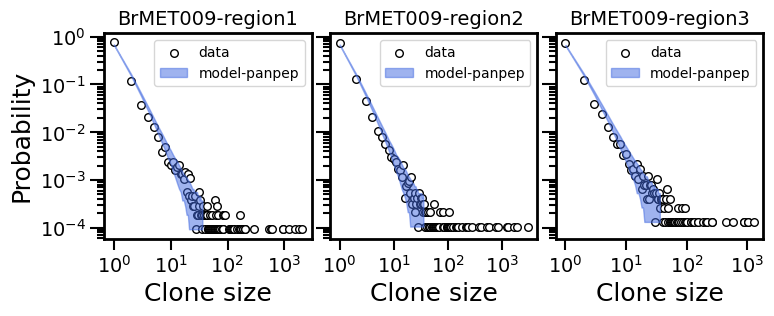

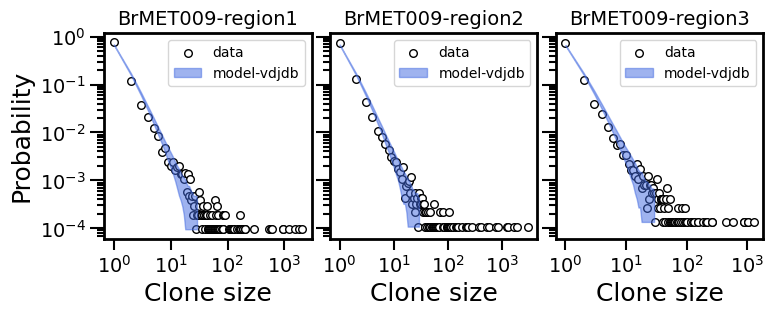

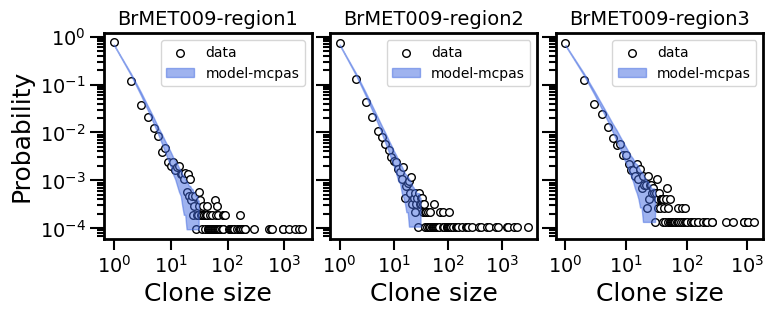

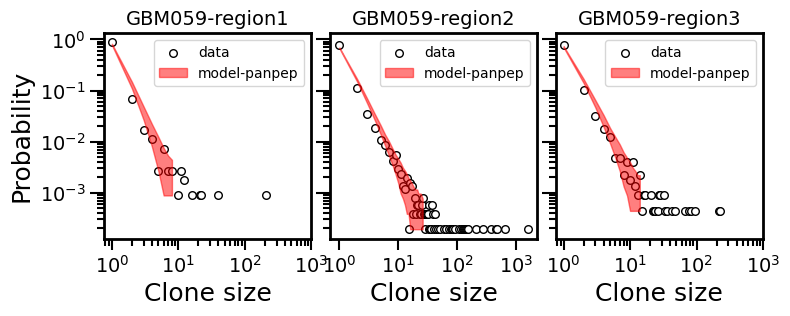

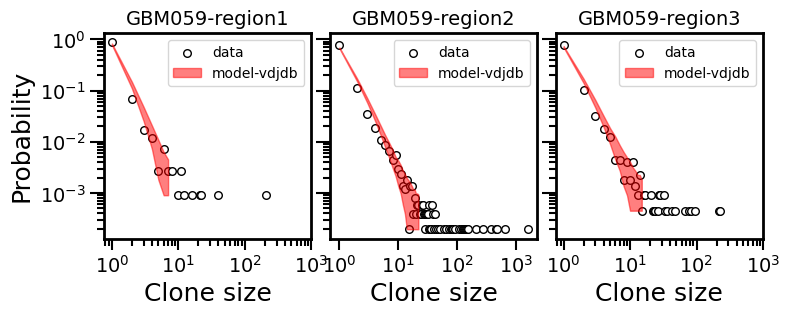

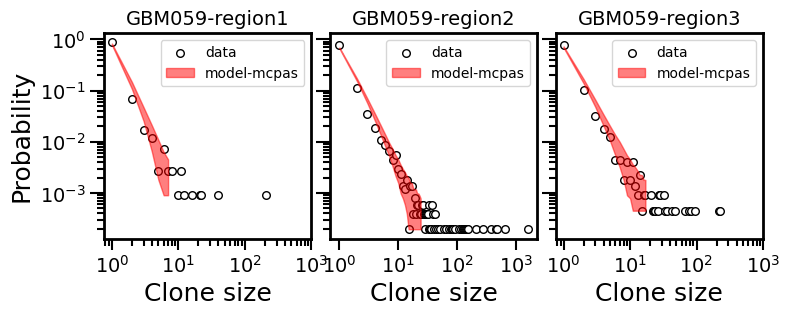

In [43]:
import matplotlib.ticker as ticker
def fig3d():
    for patient_id in ['BrMET009', 'GBM059'][:]:
        for data_type in ['panpep', 'vdjdb', 'mcpas'][:]:
            ncols = 3
            fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(8.5, 2.67), sharey=True, gridspec_kw={'wspace':0.09, 'hspace':0.15})
            for i in range(ncols):
                region_number = i+1
                with h5py.File(f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_region{region_number}_model_results_from_{data_type}.h5', 'r') as f:
                    data_config = f['data_config'][:]
                    data_config = np.unique(data_config, return_counts=True)
                    x_data, y_data = data_config[0], data_config[1] / np.sum(data_config[1])
                    
                    model_config = f['model_config'][:]
                    least_number_of_observations = 5
                    ci_df = ci_pdf(model_config, least_number_of_observations=least_number_of_observations)
                    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
                    
                    ax = axes[i]
                    facecolors = 'white'#'royalblue' if 'BrMET' in patient_id else 'red'
                    edgecolors = 'black'#darkblue' if 'BrMET' in patient_id else 'darkred'
                    ax.scatter(x_data, y_data, s=30, facecolors=facecolors, alpha=1.0, edgecolors=edgecolors, zorder=1, label='data')
                    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='royalblue' if 'BrMET' in patient_id else 'red', zorder=2, alpha=0.5, label=f'model-{data_type}')
                    
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    ax.set_xticks([1, 10, 100, 1000])  # 10^0, 10^1, 10^2, 10^3
                    ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=18)
                    offset_x = 0.30
        
                    # ax.set_xlim(min(x_data) - offset_x * min(x_data), max(x_data) + offset_x * max(x_data))
                    # ax.set_ylim(min(y_data) - offset_y * min(y_data), max(y_data) + offset_y * max(y_data))
                    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
                
                    ax.set_xlabel(r"Clone size", fontsize=18)
                    ax.set_ylabel('Probability' if i==0 else '', fontsize=18)
                    
                    ax.tick_params(
                        axis="x", which="major", direction="out", length=8, width=1.5, labelsize=14
                    )
                    ax.tick_params(
                        axis="x", which="minor", direction="out", length=5, width=1.5, labelsize=14
                    )
                    ax.tick_params(
                        axis="y", which="major", direction="out", length=10, width=1.5, labelsize=14
                    )
                    ax.tick_params(
                        axis="y", which="minor", direction="out", length=5, width=1.5, labelsize=14
                    )
                    
                    for spine in ax.spines.values():
                        spine.set_linewidth(2)
                    
                    ax.legend(loc='upper right', fontsize=10)
                    ax.set_title(f'{patient_id}-region{region_number}', fontsize=14)
            plt.savefig(f'fig3d_{patient_id}-{data_type}.png', format='png', bbox_inches='tight', dpi=300)
            plt.show()
fig3d()

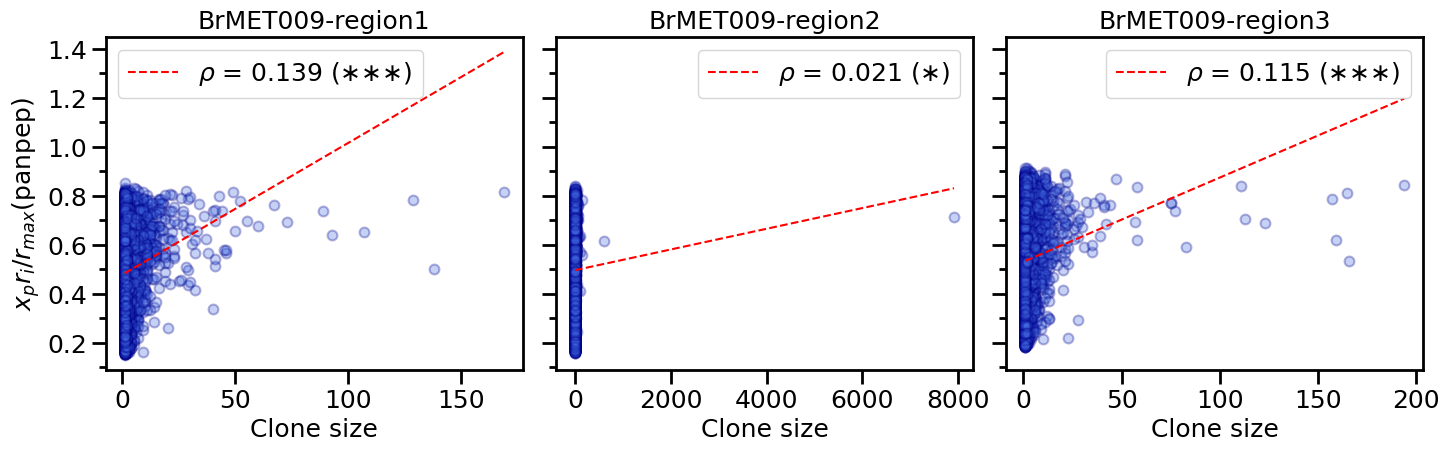

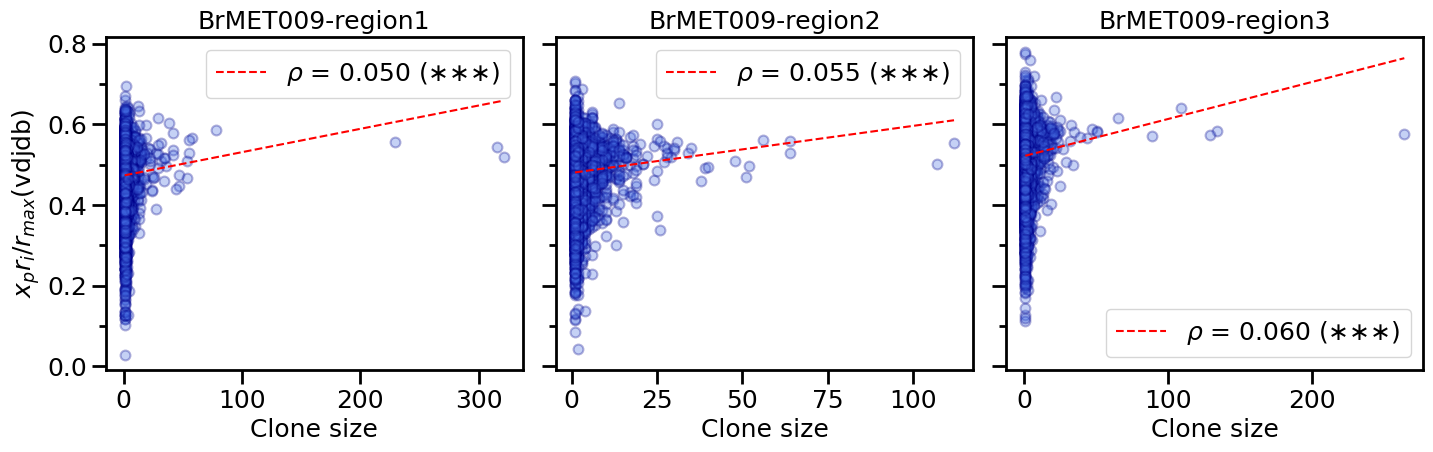

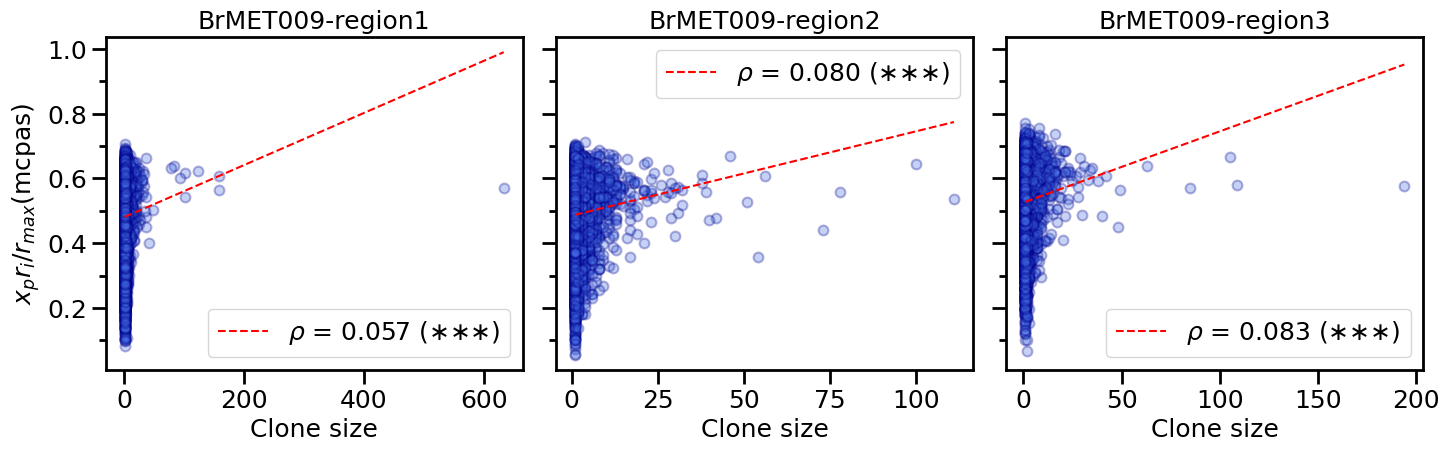

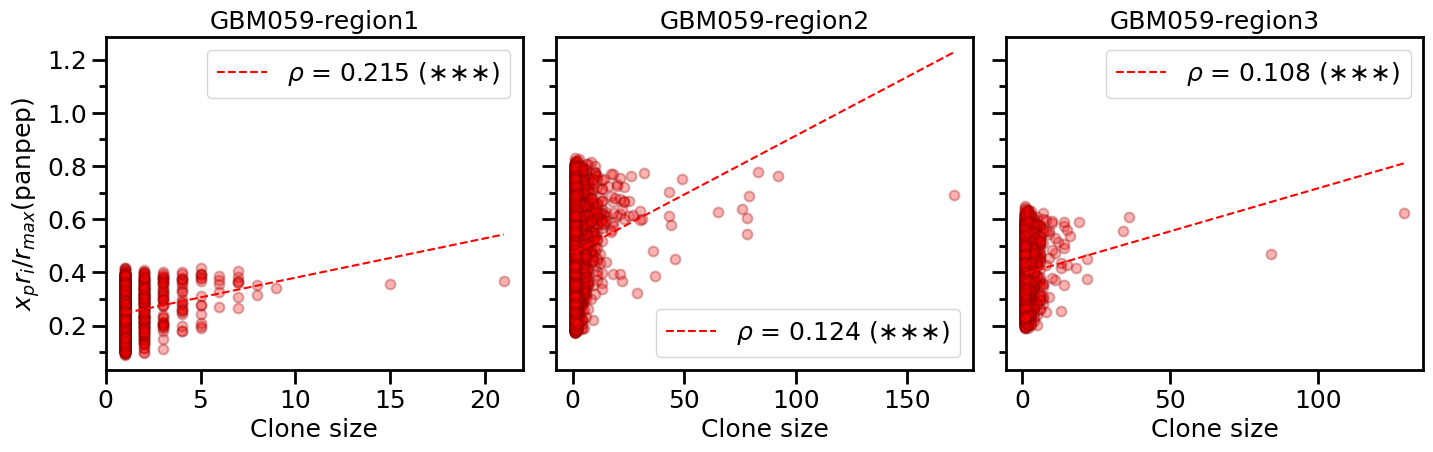

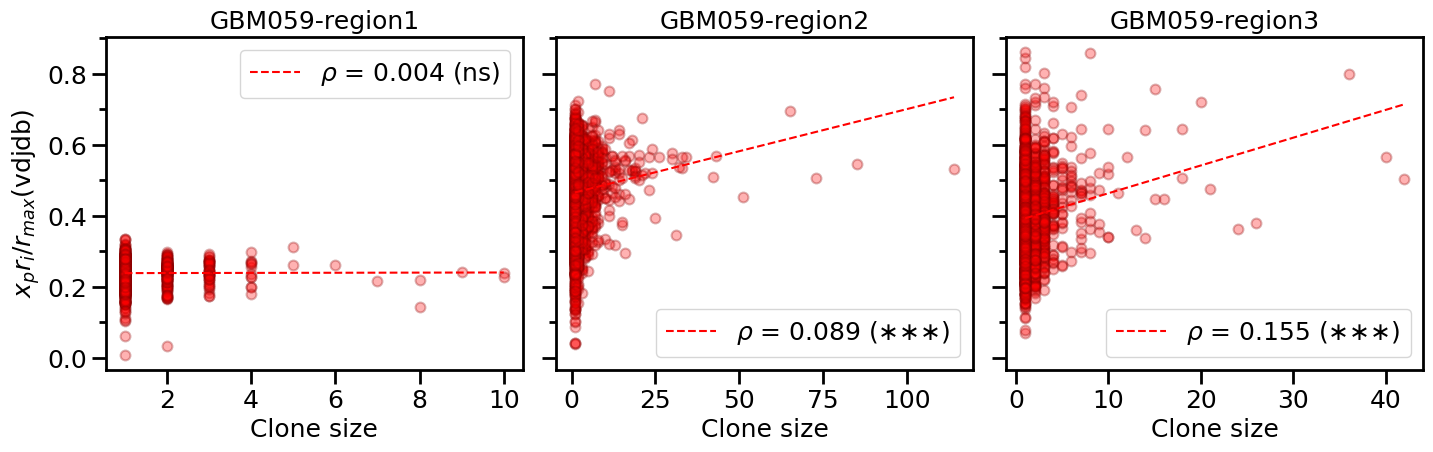

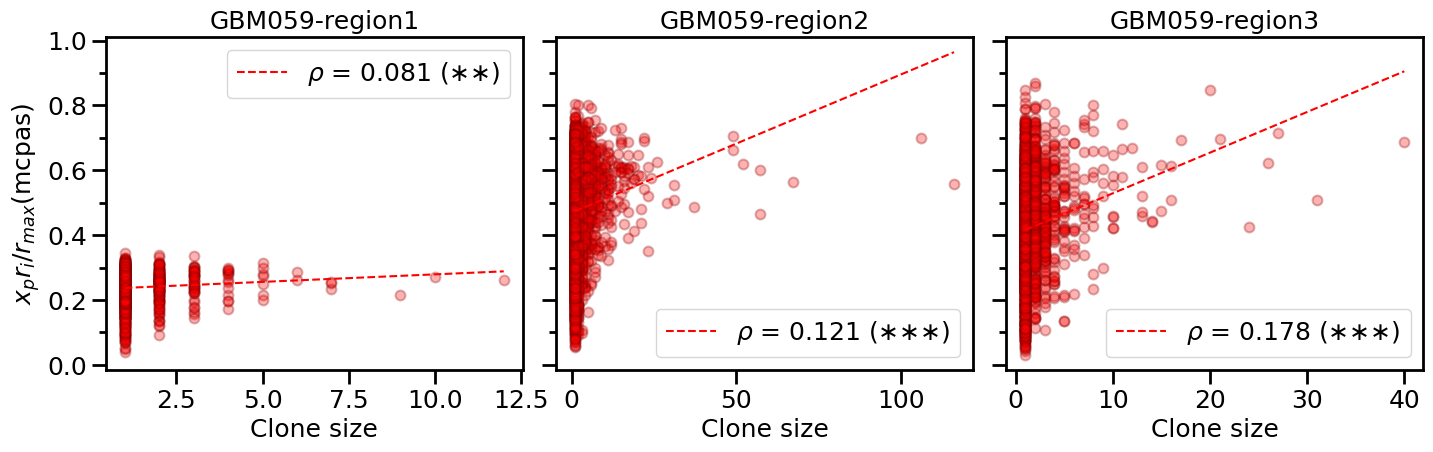

In [23]:
def fig3f():
    params_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters', )
    params_df = params_df.dropna(axis=0)
    
    for i, patient_id in enumerate(['BrMET009', 'GBM059'][:]):
        for j, data_type in enumerate(['panpep', 'vdjdb', 'mcpas']):
            ncols = 3
            fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(8.5*2, 2.16*2), sharey=True, gridspec_kw={'wspace':0.08, 'hspace':0.1})
            for k in range(ncols):
                region_number = k+1
                # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.67, 2.16*2))
                with h5py.File(f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_region{region_number}_model_results_from_{data_type}.h5', 'r') as f:
                    model_config = f['model_config'][:][:, 0]
                
                if data_type == 'panpep':
                    kr_values = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}/{patient_id}_region{region_number}.csv', sep=',', usecols=['kr'])['kr'].values
                    scaled_kr_values = kr_values/max_kr_panpep
                    x2 = params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number}')]['x2_panpep'].values[0]
                elif data_type == 'vdjdb':
                    kr_values = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/{patient_id}_region{region_number}.csv', sep=',', usecols=['kr_vdjdb'])['kr_vdjdb'].values
                    scaled_kr_values = kr_values/max_kr_vdjdb
                    x2 = params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number}')]['x2_vdjdb'].values[0]
                elif data_type == 'mcpas':
                    kr_values = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/{patient_id}_region{region_number}.csv', sep=',', usecols=['kr_mcpas'])['kr_mcpas'].values
                    scaled_kr_values = kr_values/max_kr_mcpas
                    x2 = params_df[(params_df['Patient']==patient_id) & (params_df['Region']==f'region{region_number}')]['x2_mcpas'].values[0]                
                
                x2_times_scaled_kr_values = x2 * scaled_kr_values
                
                ax = axes[k]
                facecolors = 'royalblue' if 'BrMET' in patient_id else 'red'
                edgecolors = 'darkblue' if 'BrMET' in patient_id else 'darkred'
                ax.scatter(model_config, x2_times_scaled_kr_values, s=50, facecolors=facecolors, alpha=0.3, edgecolors=edgecolors, linewidth=1.5, zorder=1)
                    
                # Calculate Pearson correlation coefficient and plot the regresssion line
                slope, intercept, r_value, p_value, _ = linregress(model_config, x2_times_scaled_kr_values)
                x_vals = np.linspace(min(model_config), max(model_config), 1000)
                y_vals = slope*x_vals + intercept
                # from scipy.stats import spearmanr
                # print(spearmanr(model_config, x2_times_scaled_kr_values))
                ax.plot(x_vals, y_vals, '--', color='red', label=fr'$\rho$ = {r_value:.3f} ({get_asterisks(p_value)})')
                
                ax.set_xlabel(r"Clone size", fontsize=18)
                ax.set_ylabel(r'$x_p r_i$/$r_{max}$' + f'({data_type})' if k==0 else '', fontsize=18)
                
                ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
                
                for label in ax.get_xticklabels():
                    label.set_fontsize(18)
                for label in ax.get_yticklabels():
                    label.set_fontsize(18)
                ax.tick_params(
                    axis="x", which="major", direction="out", length=10, width=2, labelsize=18
                )
                ax.tick_params(
                    axis="x", which="minor", direction="out", length=5, width=2, labelsize=18
                )
                ax.tick_params(
                    axis="y", which="major", direction="out", length=10, width=2, labelsize=18
                )
                ax.tick_params(
                    axis="y", which="minor", direction="out", length=5, width=2, labelsize=18
                )
                
                for spine in ax.spines.values():
                    spine.set_linewidth(2)
                
                ax.set_title(f'{patient_id}-region{region_number}', fontsize=18)
                ax.legend(loc='best', fontsize=18)
            # plt.tight_layout()
            plt.savefig(f'fig3f_{patient_id}-{data_type}.png', format='png', bbox_inches='tight', dpi=320)
            plt.show()
fig3f()

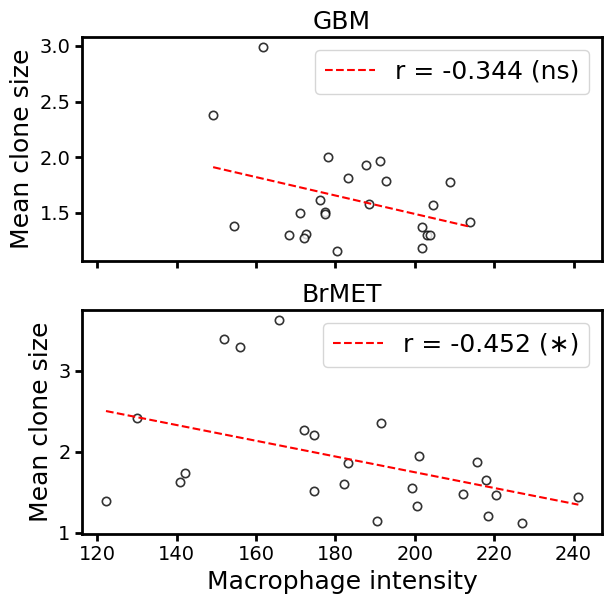

In [15]:
macrophage = pd.read_csv('/home/gddaslab/mxp140/tcr_project_ultimate/data/cell_popns.csv', usecols=['patient', 'macrophage_R', 'macrophage_G', 'macrophage_B'])
macrophage['intensity'] = (macrophage['macrophage_R'] * 0.299) + (macrophage['macrophage_G'] * 0.587) + (macrophage['macrophage_B'] * 0.114)
macrophage = macrophage.drop(columns=['macrophage_R', 'macrophage_G', 'macrophage_B'])
mean_clone_size_dict = {}
for patient_id in patient_names:
    filepath_format_for_panpep = os.path.join(find_regionwise_data_filename_for_panpep_in, patient_id, f"{patient_id}_region*.csv")
    full_filepath_for_panpep = glob.glob(filepath_format_for_panpep)
    sorted_by_region_full_filepath_for_panpep = sorted(full_filepath_for_panpep, key=lambda x: int(x.split("region")[1].split(".")[0]))
    for file_panpep in sorted_by_region_full_filepath_for_panpep:
        region_number_panpep = int(file_panpep.split("region")[1].split(".")[0])
        mean_clone_size = pd.read_csv(file_panpep)['counts'].mean()
        # print(mean_clone_size)
        mean_clone_size_dict[f'{patient_id}-region{region_number_panpep}'] = [mean_clone_size]
        
mean_clone_size_df = pd.DataFrame(data=mean_clone_size_dict).transpose().rename(columns={0: 'mean_clone_size'}).reset_index().rename(columns={'index': 'patient'})
resulting_df = pd.merge(left=macrophage, right=mean_clone_size_df, left_on='patient', right_on='patient')

nrows, ncols = 2, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex = True, figsize=(6.22, 6.14))
ax1, ax2 = axes
resulting_df1 = resulting_df[resulting_df['patient'].str.contains('GBM')]
resulting_df2 = resulting_df[resulting_df['patient'].str.contains('BrMET')]
x1 = resulting_df1['intensity'].values
y1 = resulting_df1['mean_clone_size'].values
x2 = resulting_df2['intensity'].values
y2 = resulting_df2['mean_clone_size'].values
sns.scatterplot(x='intensity', y='mean_clone_size', data=resulting_df1, facecolor='white', edgecolor='black', linewidth=1.2, alpha=0.8, ax=ax1)
sns.scatterplot(x='intensity', y='mean_clone_size', data=resulting_df2, facecolor='white', edgecolor='black', linewidth=1.2, alpha=0.8, ax=ax2)
slope1, intercept1, r_value1, p_value1, _ = linregress(x1, y1)
slope2, intercept2, r_value2, p_value2, _ = linregress(x2, y2)
x_vals1 = np.linspace(min(x1), max(x1), 1000)
y_vals1 = slope1*x_vals1 + intercept1
ax1.plot(x_vals1, y_vals1, '--', color='red', label=f'r = {r_value1:.3f} ({get_asterisks(p_value1)})')
x_vals2 = np.linspace(min(x2), max(x2), 1000)
y_vals2 = slope2*x_vals2 + intercept2
ax2.plot(x_vals2, y_vals2, '--', color='red', label=f'r = {r_value2:.3f} ({get_asterisks(p_value2)})')
for spine1, spine2 in zip(ax1.spines.values(), ax2.spines.values()):
    spine1.set_linewidth(2)
    spine2.set_linewidth(2)
ax1.set_xlabel('')
ax2.set_xlabel('Macrophage intensity', fontsize=18)
ax1.set_title('GBM', fontsize=18)
ax2.set_title('BrMET', fontsize=18)

for ax in [ax1, ax2]:
    ax.set_ylabel('Mean clone size', fontsize=18)
    ax.tick_params(axis="x", which="major", direction="out", length=5, width=2, labelsize=14)
    ax.tick_params(axis="x", which="minor", direction="out", length=3, width=2, labelsize=14)
    ax.tick_params(axis="y", which="major", direction="out", length=5, width=2, labelsize=14)
    ax.tick_params(axis="y", which="minor", direction="out", length=3, width=2, labelsize=14)
    ax.legend(loc='best', fontsize=18)

plt.tight_layout()
plt.show()